In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import log2

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud

sns.set(style="whitegrid", font_scale=1.2)

In [5]:
df = pd.read_csv("data/train.csv")

print("Dataset shape:", df.shape)
print(df.head())

Dataset shape: (49496, 11)
   id  query_id                         query product_id  \
0  27  q_000002          disturb, jeidah bila  p_0000027   
1  28  q_000002  #do not disturb, jeidah bila  p_0000028   
2  29  q_000002      #do disturb, jeidah bila  p_0000029   
3  30  q_000002              #do not disturb,  p_0000030   
4  31  q_000002         #do not disturb, bila  p_0000031   

                                       product_title  \
0  bila sleevless enforcing bleach asymmetrical d...   
1  french connection women s classic crepe light ...   
2  3d socks unisex adult animal paw crew socks - ...   
3  bila womens sleeveless blouse 156 fenchilin to...   
4  bila womens sleeveless rayon maxi 30g unmatche...   

                                 product_description  \
0  <p>bila print flowy sleeveless rayon dress per...   
1                                               none   
2  <b>unisex funny men 3d lifelike animal paw soc...   
3  material: 100%-rayon, care: hand wash water, l..

In [6]:
def idcg_at_k(rels, k=10):
    rels = sorted(rels, reverse=True)[:k]
    return sum((2**rel - 1) / log2(i + 2) for i, rel in enumerate(rels))

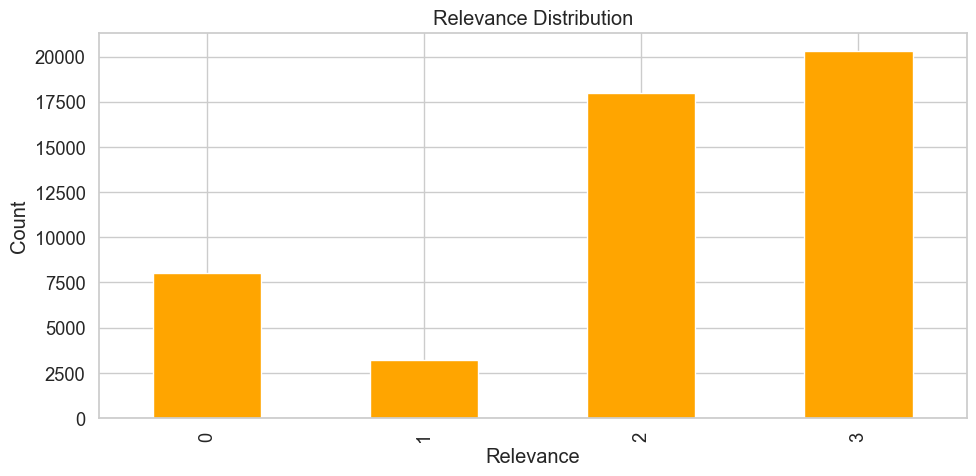

In [7]:
# Distribution of relevance
plt.figure(figsize=(10, 5))
df["relevance"].value_counts().sort_index().plot(kind="bar", color="orange")
plt.title("Relevance Distribution")
plt.xlabel("Relevance")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

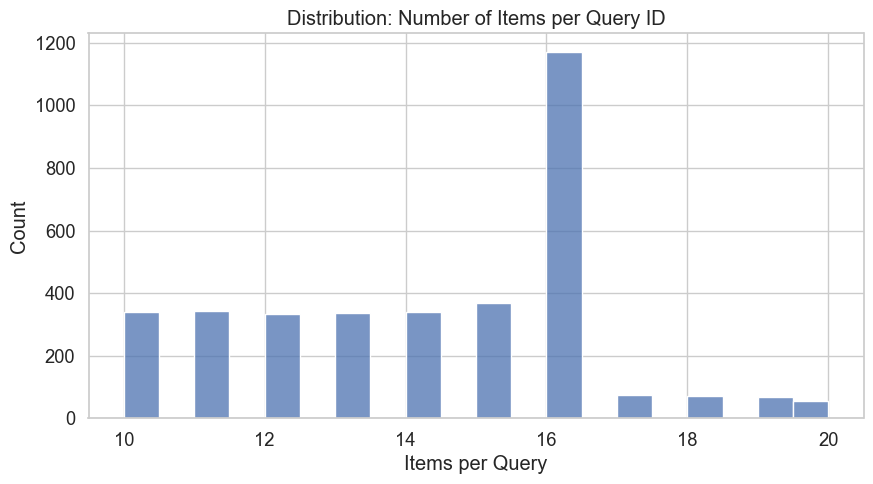

query_id
q_000002    17
q_000003    20
q_000004    19
q_000005    13
q_000007    15
            ..
q_004995    10
q_004996    19
q_004997    12
q_004998    13
q_004999    12
Name: id, Length: 3500, dtype: int64


In [8]:
# Number of items per query_id
query_sizes = df.groupby("query_id")["id"].count()
plt.figure(figsize=(10, 5))
sns.histplot(query_sizes, bins=20)
plt.title("Distribution: Number of Items per Query ID")
plt.xlabel("Items per Query")
plt.ylabel("Count")
plt.show()
print(query_sizes)

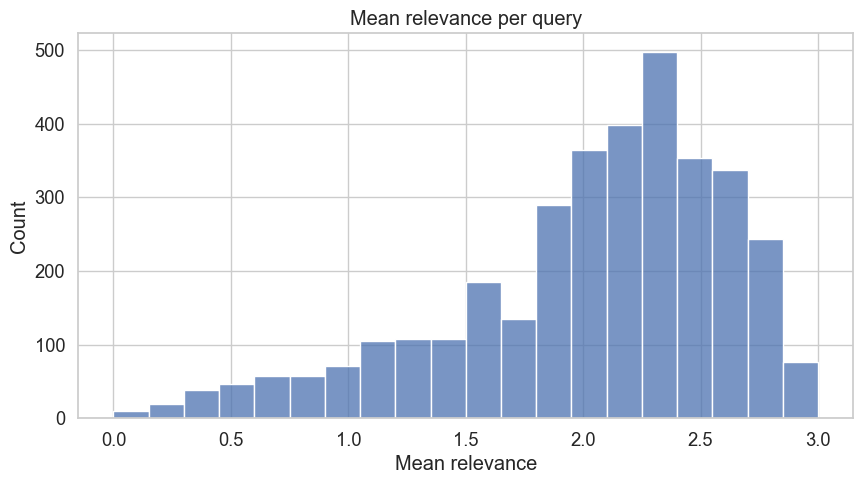

count    3500.000000
mean        2.022192
std         0.602007
min         0.000000
25%         1.722222
50%         2.153846
75%         2.451136
max         3.000000
Name: relevance, dtype: float64


In [9]:
# Mean relevance per query
mean_rel = df.groupby("query_id")["relevance"].mean()

plt.figure(figsize=(10, 5))
sns.histplot(mean_rel, bins=20)
plt.title("Mean relevance per query")
plt.xlabel("Mean relevance")
plt.ylabel("Count")
plt.show()

print(mean_rel.describe())

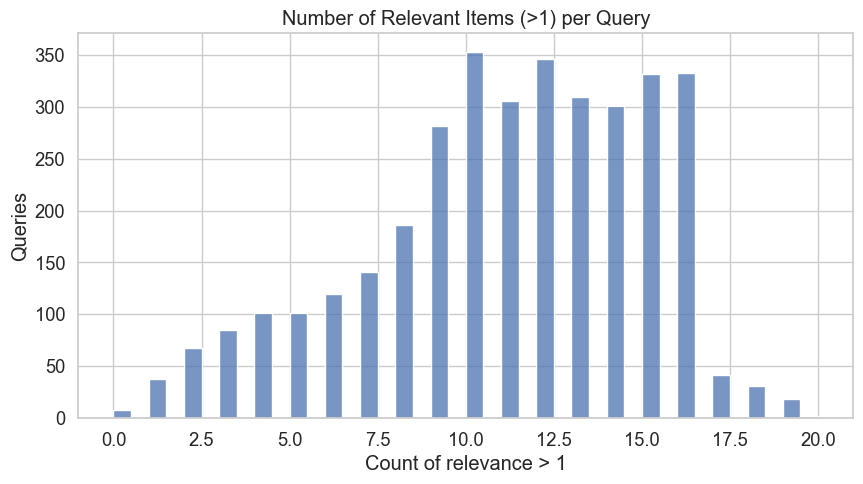

count    3500.000000
mean       10.937143
std         3.964337
min         0.000000
25%         9.000000
50%        11.000000
75%        14.000000
max        20.000000
Name: relevance, dtype: float64


In [10]:
# Count of relevant items (>1) per query
rel_above_1 = df.groupby("query_id")["relevance"].apply(lambda x: (x > 1).sum())

plt.figure(figsize=(10, 5))
sns.histplot(rel_above_1, bins=40)
plt.title("Number of Relevant Items (>1) per Query")
plt.xlabel("Count of relevance > 1")
plt.ylabel("Queries")
plt.show()

print(rel_above_1.describe())

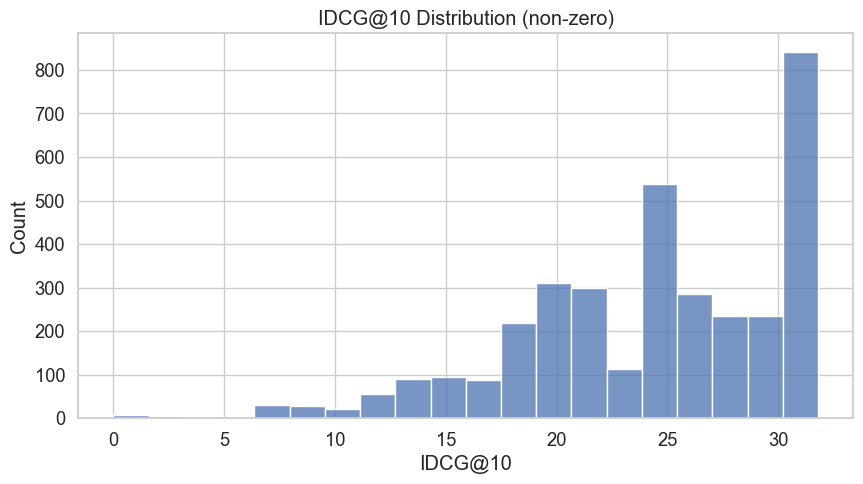

count    3500.000000
mean       24.471896
std         6.145980
min         0.000000
25%        20.154397
50%        25.424514
75%        29.444536
max        31.804915
Name: relevance, dtype: float64


In [11]:
# IDCG@10 distribution
idcg_values = (
    df.groupby("query_id")["relevance"]
    .apply(lambda rels: idcg_at_k(rels.tolist(), k=10))
)

plt.figure(figsize=(10, 5))
sns.histplot(idcg_values, bins=20)
plt.title("IDCG@10 Distribution (non-zero)")
plt.xlabel("IDCG@10")
plt.ylabel("Count")
plt.show()

print(idcg_values.describe())

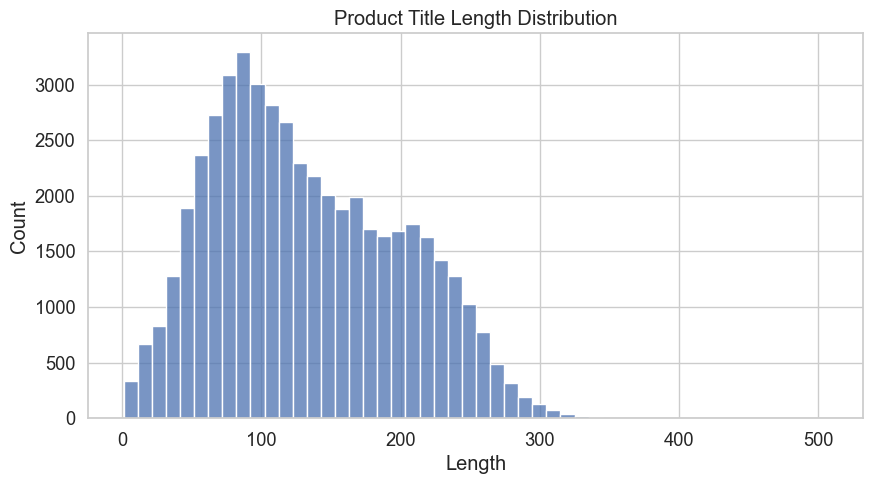

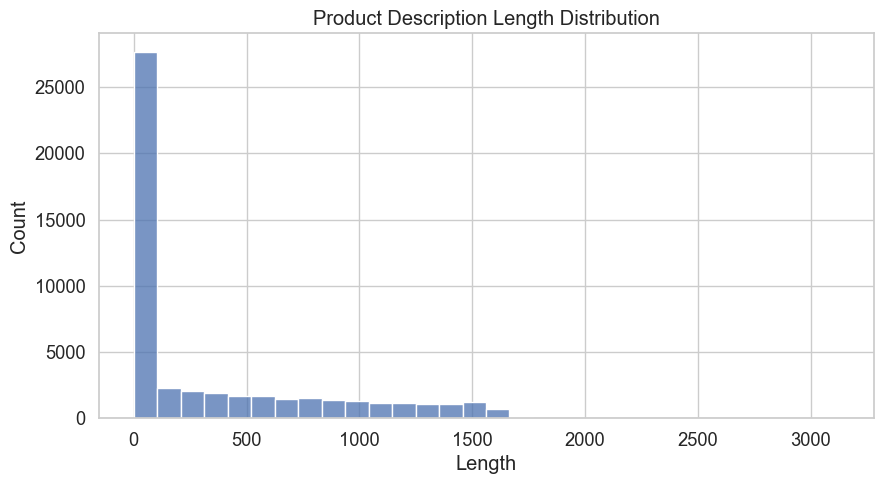

(15,)


47041    0
31452    1
30557    1
32379    1
30561    1
Name: desc_len, dtype: int64

In [12]:
# Text length analysis
df["title_len"] = df["product_title"].fillna("").apply(len)
df["desc_len"] = df["product_description"].fillna("").apply(len)

plt.figure(figsize=(10, 5))
sns.histplot(df["title_len"], bins=50)
plt.title("Product Title Length Distribution")
plt.xlabel("Length")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(df["desc_len"], bins=30)
plt.title("Product Description Length Distribution")
plt.xlabel("Length")
plt.ylabel("Count")
plt.show()
print(df["desc_len"][df["desc_len"] == 3].shape)
df.sort_values("desc_len")["desc_len"].head()

In [13]:
# Example of good/bad queries

# Query with many relevant items
best_query = (
    df.groupby("query_id")["relevance"]
    .apply(lambda x: (x == 3).sum())
    .sort_values(ascending=False)
    .index[0]
)

print("\n===== Example: Query with many highly relevant items =====")
print(df[df["query_id"] == best_query][["query", "product_title", "relevance"]].head())

# Query with all irrelevant items
worst_query = (
    df.groupby("query_id")["relevance"].mean()
    .sort_values()
    .index[0]
)

print("\n===== Example: Query with lowest mean relevance =====")
print(df[df["query_id"] == worst_query][["query", "product_title", "relevance"]].head())


===== Example: Query with many highly relevant items =====
                                query  \
41861                  glasses adults   
41862                 straw for drink   
41863         straw glasses for drink   
41864                 straw for drink   
41865  straw glasses for adults drink   

                                           product_title  relevance  
41861  bokon 8 pieces silly straw glasses crazy straw...          3  
41862  silly kids fun glasses rejuvenated straws 10 s...          3  
41863  4 pcs silly straw fabric glasses,reusable fun ...          3  
41864  costimo multi color straw eyeglasses crazy sil...          3  
41865  8 pieces silly straw glasses eyeglasses straws...          3  

===== Example: Query with lowest mean relevance =====
                          query  \
0          disturb, jeidah bila   
1  #do not disturb, jeidah bila   
2      #do disturb, jeidah bila   
3              #do not disturb,   
4         #do not disturb, bila   

       

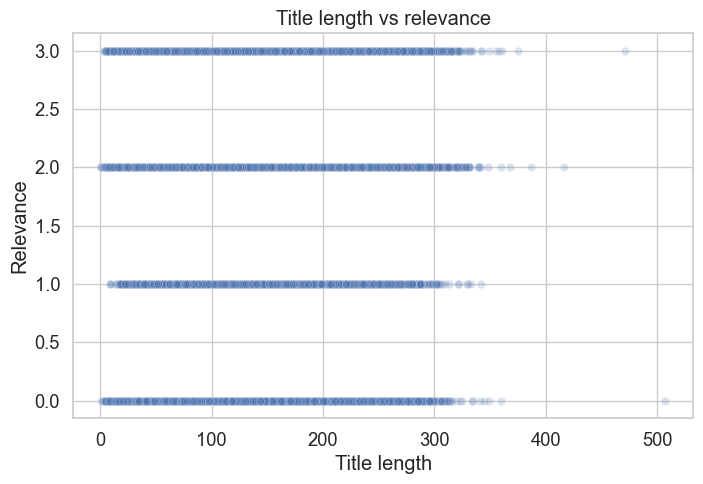

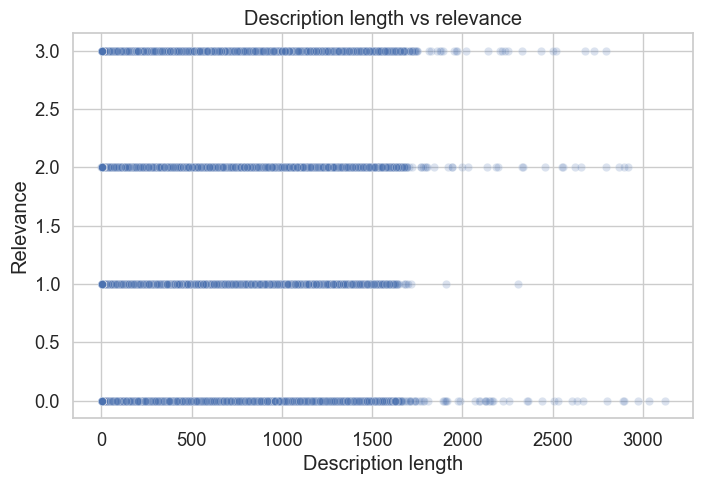

In [14]:
# Correlation: does longer text correlate with relevance?
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df["title_len"], y=df["relevance"], alpha=0.2)
plt.title("Title length vs relevance")
plt.xlabel("Title length")
plt.ylabel("Relevance")
plt.show()

plt.figure(figsize=(8, 5))
sns.scatterplot(x=df["desc_len"], y=df["relevance"], alpha=0.2)
plt.title("Description length vs relevance")
plt.xlabel("Description length")
plt.ylabel("Relevance")
plt.show()

In [16]:
text_cols = [
    "product_title",
    "product_description",
    "product_bullet_point",
    "product_brand",
    "product_color"
]

for c in text_cols:
    df[c] = df[c].fillna("")

df["product_text"] = df[text_cols].agg(" ".join, axis=1)

In [17]:
# Check missing values
missing = df.isnull().sum()
print("\nMissing values:")
print(missing)


===== STRUCTURAL ANALYSIS =====

Missing values:
id                      0
query_id                0
query                   0
product_id              0
product_title           0
product_description     0
product_bullet_point    0
product_brand           0
product_color           0
product_locale          0
relevance               0
title_len               0
desc_len                0
product_text            0
dtype: int64



Empty product_text rows: 0


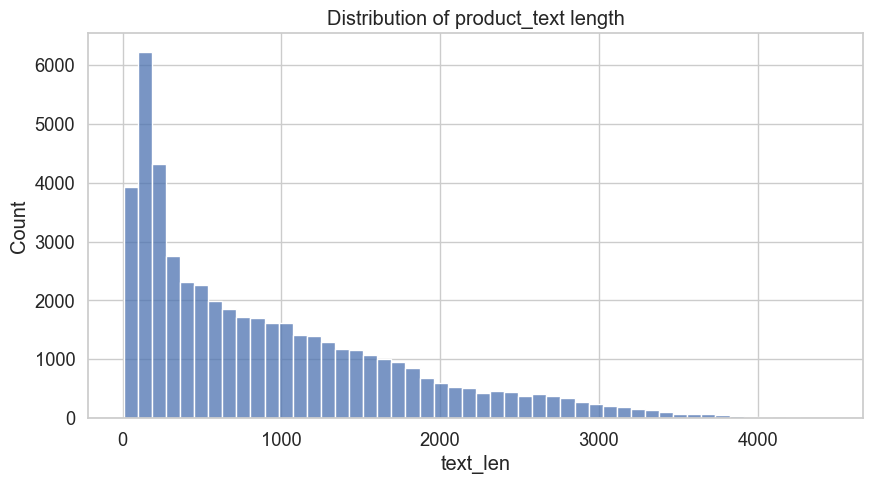

In [18]:
# Empty text problem
df["text_len"] = df["product_text"].apply(lambda x: len(x.strip()))
empty_text_count = (df["text_len"] == 0).sum()
print("\nEmpty product_text rows:", empty_text_count)

plt.figure(figsize=(10, 5))
sns.histplot(df["text_len"], bins=50)
plt.title("Distribution of product_text length")
plt.show()

In [19]:
# Check duplicated products for different queries
duplicated_products = df[df.duplicated("product_id", keep=False)]
print("\nDuplicated products across queries (possible leakage):", duplicated_products.shape[0])


Duplicated products across queries (possible leakage): 2683



Query size stats:
count    3500.000000
mean       14.141714
std         2.427321
min        10.000000
25%        12.000000
50%        15.000000
75%        16.000000
max        20.000000
Name: id, dtype: float64


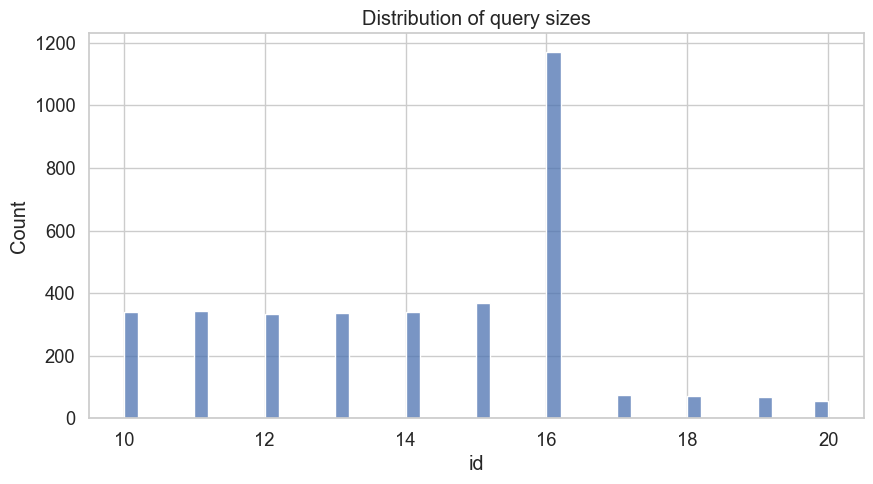

In [20]:
# Query-level imbalance
query_sizes = df.groupby("query_id")["id"].count()
print("\nQuery size stats:")
print(query_sizes.describe())

plt.figure(figsize=(10, 5))
sns.histplot(query_sizes, bins=50)
plt.title("Distribution of query sizes")
plt.show()

In [21]:
# Relabeling check (are some queries all zero?)
zero_queries = df.groupby("query_id")["relevance"].max()
zero_queries = (zero_queries == 0).sum()
print("\nQueries with all zero relevance:", zero_queries)


Queries with all zero relevance: 6


In [22]:
# ============================================================
# TF-IDF VECTORIZATION
# ============================================================

print("\n===== TF-IDF VECTOR ANALYSIS =====")
tfidf = TfidfVectorizer(
    max_features=20_000,
    ngram_range=(1, 2),
    min_df=3,
    stop_words="english"
)

X = tfidf.fit_transform(df["product_text"])

print("TF-IDF shape:", X.shape)


===== TF-IDF VECTOR ANALYSIS =====
TF-IDF shape: (49496, 20000)


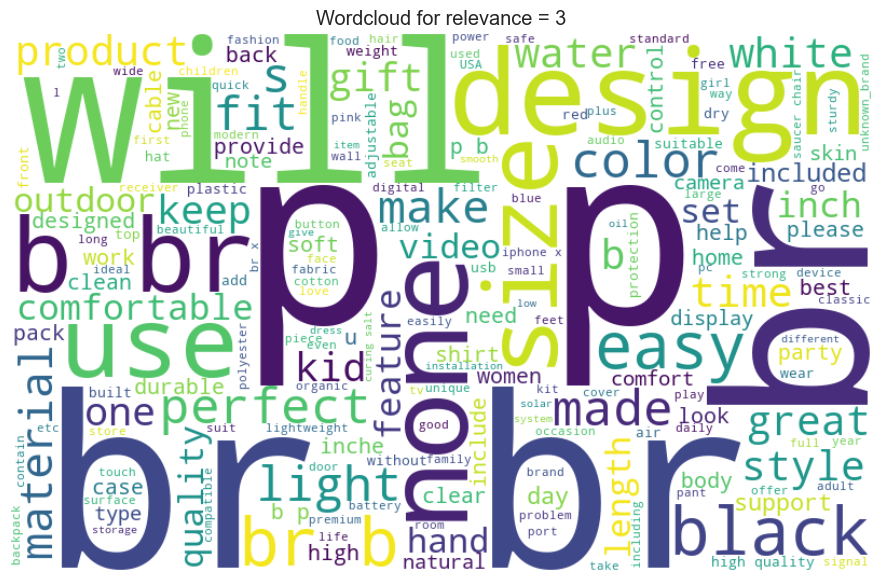

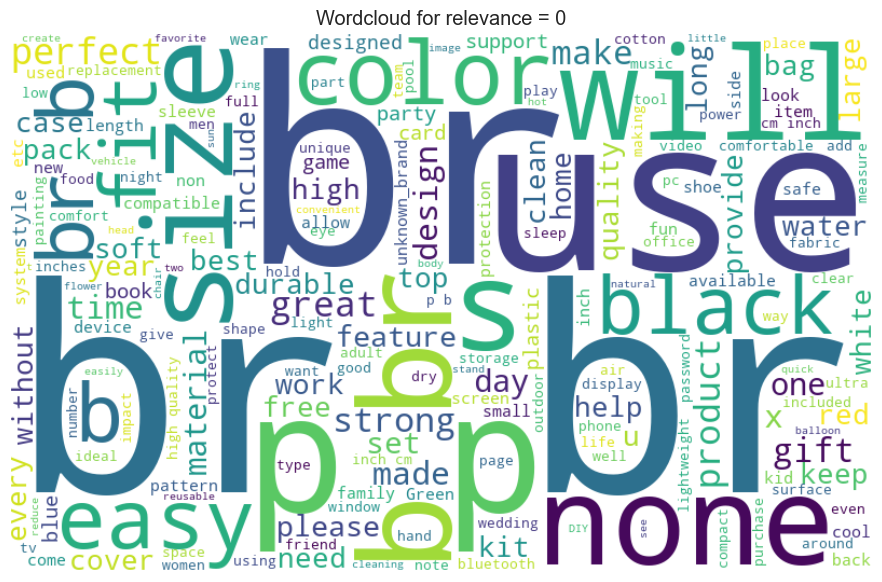

In [23]:
# ============================================================
# WORDCLOUD VISUALIZATION (relevance segments)
# ============================================================

def show_wordcloud(text, title):
    wc = WordCloud(width=800, height=500, background_color="white").generate(" ".join(text))
    plt.figure(figsize=(12, 7))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

# Most relevant = relevance 3
top_text = df[df["relevance"] == 3]["product_text"].sample(200, random_state=1)
show_wordcloud(top_text, "Wordcloud for relevance = 3")

# Irrelevant = 0
bad_text = df[df["relevance"] == 0]["product_text"].sample(200, random_state=1)
show_wordcloud(bad_text, "Wordcloud for relevance = 0")

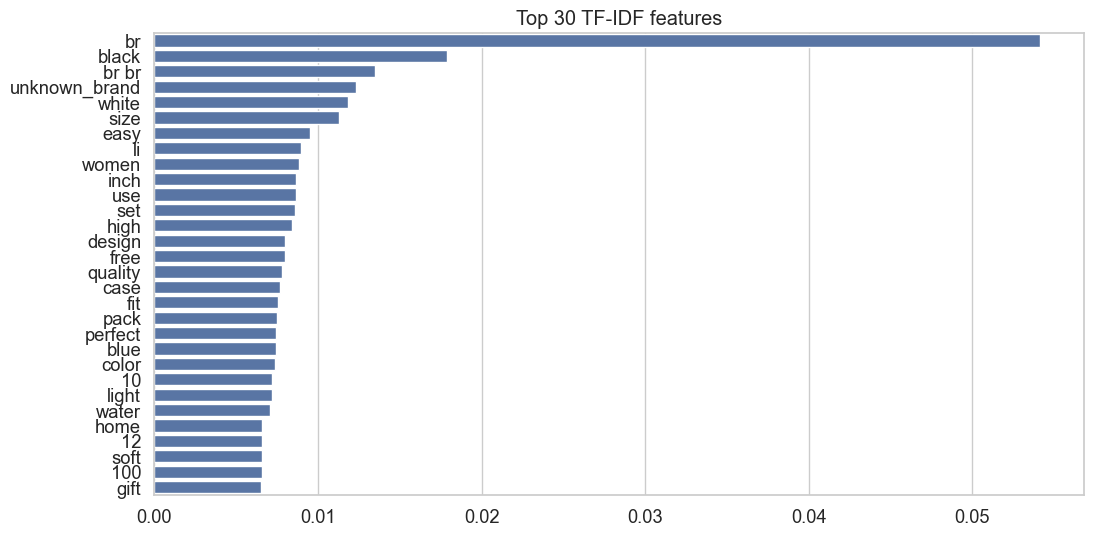

In [24]:
# ============================================================
# VISUALIZE MOST IMPORTANT TF-IDF FEATURES
# ============================================================

features = np.array(tfidf.get_feature_names_out())
mean_tfidf = np.asarray(X.mean(axis=0)).ravel()
top_idx = mean_tfidf.argsort()[::-1][:30]

plt.figure(figsize=(12, 6))
sns.barplot(x=mean_tfidf[top_idx], y=features[top_idx])
plt.title("Top 30 TF-IDF features")
plt.show()

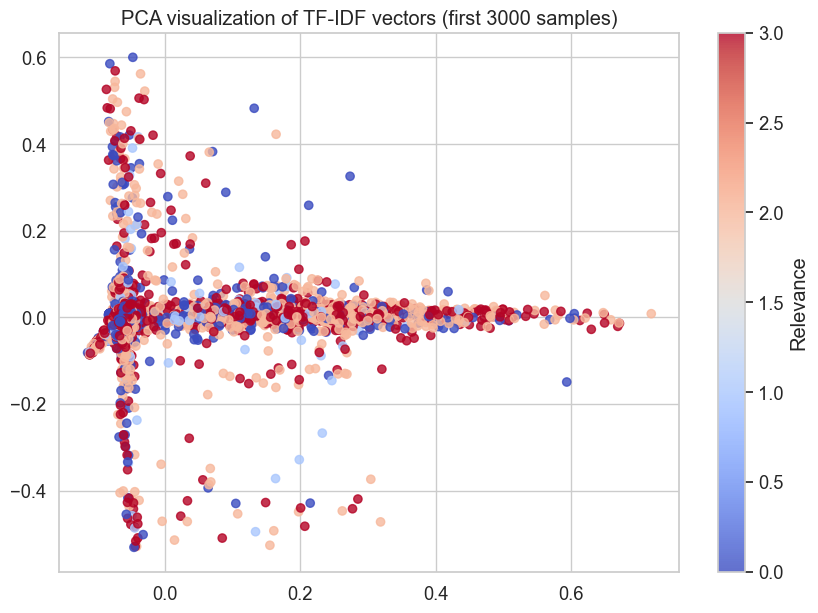

In [30]:
# ============================================================
# PCA VISUALIZATION OF TF-IDF SPACE
# ============================================================

pca = PCA(n_components=2)
X_small = X[:5000]
X_pca = pca.fit_transform(X_small.toarray())

sample_rel = df["relevance"][:5000]

plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1],
            c=sample_rel, cmap="coolwarm", alpha=0.8)
plt.colorbar(label="Relevance")
plt.title("PCA visualization of TF-IDF vectors (first 3000 samples)")
plt.show()

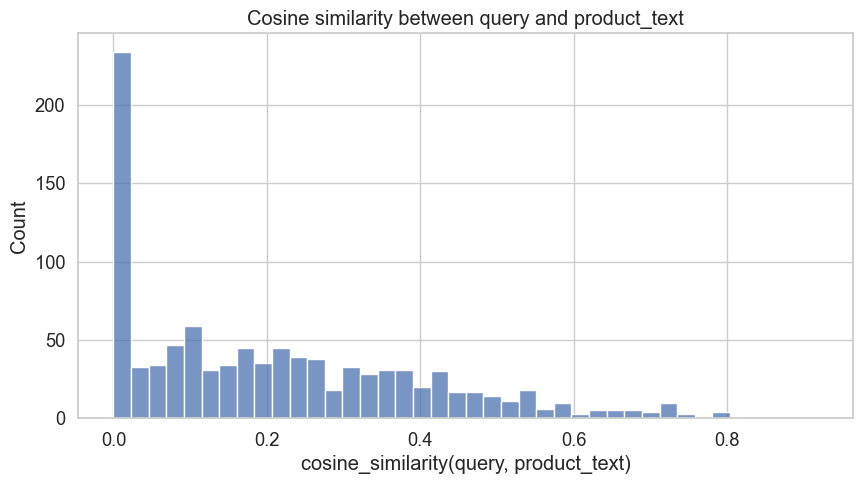


Correlation relevance ↔ similarity: 0.10415856096237389


In [26]:
# ============================================================
# QUERY–PRODUCT SIMILARITY ANALYSIS
# ============================================================

sample_df = df.sample(1000, random_state=1)

query_tfidf = tfidf.transform(sample_df["query"])
prod_tfidf = tfidf.transform(sample_df["product_text"])

cos_sim = np.diag(cosine_similarity(query_tfidf, prod_tfidf))

plt.figure(figsize=(10, 5))
sns.histplot(cos_sim, bins=40)
plt.title("Cosine similarity between query and product_text")
plt.xlabel("cosine_similarity(query, product_text)")
plt.show()

print("\nCorrelation relevance <-> similarity:", np.corrcoef(cos_sim, sample_df["relevance"])[0,1])